In [50]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od
import pandas as pd
import os
import shutil
import splitfolders
#from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)
dataset_dir = './defungi'
output_dir = './Train_test_split'

#Split into train, test, validation
splitfolders.ratio(dataset_dir, output=output_dir, seed=42, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 9114 files [00:10, 836.28 files/s]


In [12]:
train_data_dir = './Train_test_split/train'
test_data_dir = './Train_test_split/test'
val_data_dir = './Train_test_split/val'

In [27]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.2,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                        #val_data_dir
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.2,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 5466 files belonging to 5 classes.
Using 4373 files for training.
Found 5466 files belonging to 5 classes.
Using 1093 files for validation.
Found 1829 files belonging to 5 classes.


In [14]:
class_names = train_data.class_names
class_names

['H1', 'H2', 'H3', 'H5', 'H6']

In [16]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


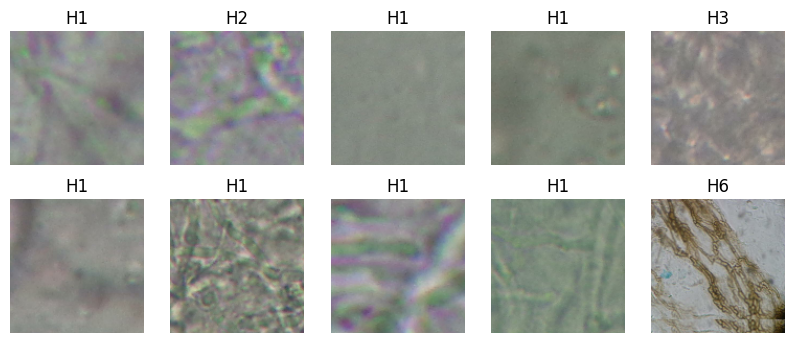

In [17]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [18]:
#Scaling Images
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[186.64062  183.        99.453125]
   [182.       180.45312   96.359375]
   [183.8125   184.71875   99.625   ]
   ...
   [108.87964  103.87964   38.41089 ]
   [115.1875   107.828125  40.90625 ]
   [117.       110.        40.      ]]

  [[177.88818  182.53784  102.61597 ]
   [177.28125  183.       102.4375  ]
   [178.54688  186.73608  105.15625 ]
   ...
   [106.375    101.375     35.90625 ]
   [112.4104   105.051025  38.12915 ]
   [116.       109.        41.      ]]

  [[171.61401  179.01562  108.05151 ]
   [169.56421  179.56421  107.81421 ]
   [170.46875  182.73438  109.796875]
   ...
   [105.734375 100.734375  35.265625]
   [111.736084 104.37671   37.454834]
   [115.       107.        42.53125 ]]

  ...

  [[167.1875   173.28125  106.1875  ]
   [158.64062  154.5625   100.640625]
   [148.5393   140.92944   92.265625]
   ...
   [143.80493  136.46875   59.265625]
   [141.52954  134.73438   57.53125 ]
   [136.45312  134.45312   59.453125]]

  [[166.09375  173.82812  104.6406

In [19]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

c:\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [51]:
# Convert the TensorFlow dataset to NumPy arrays for SMOTE
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_data)

In [54]:
# Flatten the images for SMOTE
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape back to the original image dimensions
X_resampled = X_resampled.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Convert back to TensorFlow dataset
train_data_smote = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled)).batch(BATCH_SIZE)

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_data_smote = train_data_smote.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

# Check the class distribution after SMOTE
unique, counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")

Class distribution after SMOTE: {0: 2146, 1: 2146, 2: 2146, 3: 2146, 4: 2146}


In [55]:
#Model Building
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
#model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [56]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,429 (6.13 MB)

 Trainable params: 1,606,469 (6.13 MB)

 Non-trainable params: 960 (3.75 KB)

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                #from_logits=True,
                ignore_class=None,
                reduction='sum_over_batch_size'
              ),
              metrics=['accuracy'])

In [58]:
#Model Training
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data
                    )

end_time = time.time()

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - accuracy: 0.5294 - loss: 1.2984 - val_accuracy: 0.1967 - val_loss: 1.6886
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 497ms/step - accuracy: 0.6090 - loss: 0.9860 - val_accuracy: 0.4328 - val_loss: 1.4456
Epoch 3/20
112/137 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 0.6326 - loss: 0.9275

KeyboardInterrupt: 

In [46]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 1393.470 seconds
